# Building a Euribor Curve - Interpolation Analysis - Simple Case

We build an Ibor single-curve and examine different interpolation choices for a simple curve.

This follows:

https://quant.stackexchange.com/questions/53904/monotonic-cubic-spline-interpolation-quantlib-python?rq=1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.finutils import *
from financepy.products.funding import *

####################################################################
# FINANCEPY BETA Version 0.185 - This build:  30 Oct 2020 at 11:34 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



In [3]:
valuationDate = FinDate(12, 5, 2020)

## Building the Single Curve

Build the Ibor Curve

In [4]:
cal = FinCalendarTypes.TARGET

depoDCCType = FinDayCountTypes.ACT_360
depos = []
spotDays = 0
settlementDate = valuationDate.addWeekDays(spotDays)
depo = FinIborDeposit(settlementDate, "6M", -0.114/100.0, depoDCCType, calendarType=cal); depos.append(depo)
fraDCCType = FinDayCountTypes.ACT_360

fras = []
fra = FinIborFRA(settlementDate.addTenor("6M"), "6M", -0.252/100.0, fraDCCType, calendarType=cal); fras.append(fra)
fra = FinIborFRA(settlementDate.addTenor("12M"), "6M", -0.306/100.0, fraDCCType, calendarType=cal); fras.append(fra)

swaps = []
swapType = FinSwapTypes.PAYER
fixedDCCType = FinDayCountTypes.THIRTY_E_360_ISDA
fixedFreqType = FinFrequencyTypes.ANNUAL

swap = FinIborSwap(settlementDate, "2Y", swapType, -0.325/100.0, fixedFreqType, fixedDCCType, calendarType=cal); swaps.append(swap)
swap = FinIborSwap(settlementDate, "3Y", swapType, -0.347/100.0, fixedFreqType, fixedDCCType, calendarType=cal); swaps.append(swap)

iborDepos = depos.copy()
iborFras = fras.copy()
iborSwaps = swaps.copy()

In [5]:
iborCurves = {}
for interpType in FinInterpTypes:
    iborCurve = FinIborSingleCurve(valuationDate, iborDepos, iborFras, iborSwaps, interpType)
    iborCurves[interpType] = iborCurve

Set up a list of dates

In [6]:
gridDates = []
dt = FinDate(12, 5, 2020); gridDates.append(dt)
dt = dt.addTenor("6M"); gridDates.append(dt)
dt = dt.addTenor("6M"); gridDates.append(dt)
dt = dt.addTenor("6M"); gridDates.append(dt)
dt = dt.addTenor("6M"); gridDates.append(dt)
dt = dt.addTenor("12M"); gridDates.append(dt)

In [7]:
print("               ", end="")

for interp in FinInterpTypes:
    print("%14s "% (str(interp))[15:], end="")
print("")
    
for dt in gridDates:
    print("%12s"% dt, end="")
    for interp in FinInterpTypes:
        iborCurve = iborCurves[interp]
        df = iborCurve.df(dt) / iborCurve.df(settlementDate)
        print("%14.7f "% (df), end="")
    print("")

               FLAT_FWD_RATES LINEAR_FWD_RATES LINEAR_SWAP_RATES LINEAR_ZERO_RATES LINEAR_LOG_DFS CUBIC_ZERO_RATES  CUBIC_LOG_DFS 
TUE 12 MAY 2020     1.0000000      1.0000000      1.0000000      1.0000000      1.0000000      1.0000000      1.0000000 
THU 12 NOV 2020     1.0005830      1.0005830      1.0005830      1.0005830      1.0005830      1.0005830      1.0005830 
WED 12 MAY 2021     1.0018524      1.0018524      1.0018524      1.0018524      1.0018524      1.0018524      1.0018524 
FRI 12 NOV 2021     1.0034217      1.0034217      1.0034217      1.0034217      1.0034217      1.0034217      1.0034217 
THU 12 MAY 2022     1.0065272      1.0065272      1.0065272      1.0065272      1.0065272      1.0065272      1.0065272 
FRI 12 MAY 2023     1.0104754      1.0104754      1.0104754      1.0104754      1.0104754      1.0104754      1.0104754 


This agrees perfectly with QL.

Now shift the dates and you see the different impact of the different interpolation schemes.

In [8]:
shiftedDates = []
for dt in gridDates:
    shiftedDates.append(dt.addTenor("15D"))

In [9]:
print("             ", end="")

for interp in FinInterpTypes:
    print("%14s "% (str(interp))[15:], end="")
print("")
    
for dt in shiftedDates:
    print("%12s"% dt.str("X"), end="")
    for interp in FinInterpTypes:
        iborCurve = iborCurves[interp]
        df = iborCurve.df(dt) / iborCurve.df(settlementDate)
        print("%14.7f "% (df), end="")
    print("")

             FLAT_FWD_RATES LINEAR_FWD_RATES LINEAR_SWAP_RATES LINEAR_ZERO_RATES LINEAR_LOG_DFS CUBIC_ZERO_RATES  CUBIC_LOG_DFS 
   27MAY2020     1.0000475      1.0000475      1.0000475      1.0000475      1.0000475      1.0000475      1.0000217 
   27NOV2020     1.0006881      1.0006353      1.0006619      1.0006619      1.0006881      1.0006361      1.0006541 
   27MAY2021     1.0019802      1.0019595      1.0019643      1.0019643      1.0019802      1.0019709      1.0019665 
   27NOV2021     1.0036787      1.0035604      1.0036416      1.0036416      1.0036787      1.0036059      1.0036105 
   27MAY2022     1.0066892      1.0067811      1.0066804      1.0066804      1.0066892      1.0066979      1.0067305 
   27MAY2023     1.0106380      1.0106380      1.0106197      1.0106197      1.0106380      1.0106185      1.0105701 


This shows that the interpolations do not match once we are off the grid times.

## Curve Shape Analysis

Look at short end

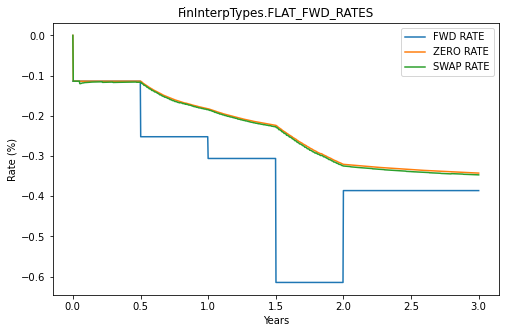

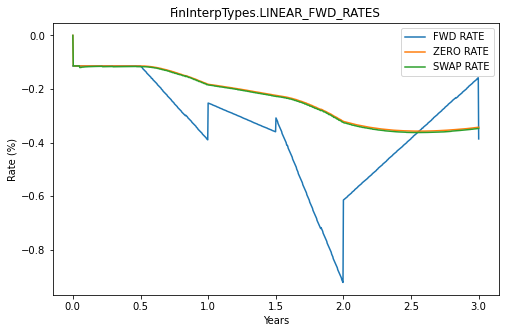

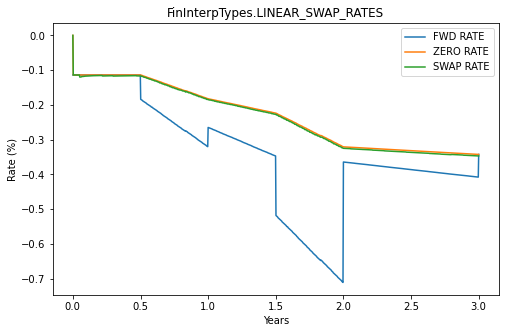

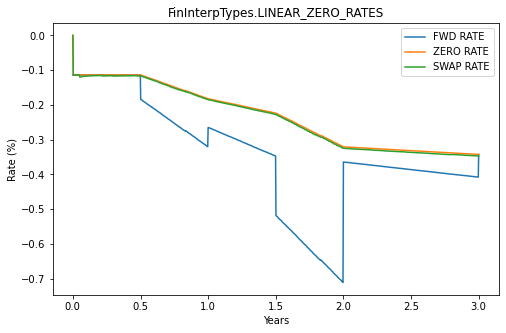

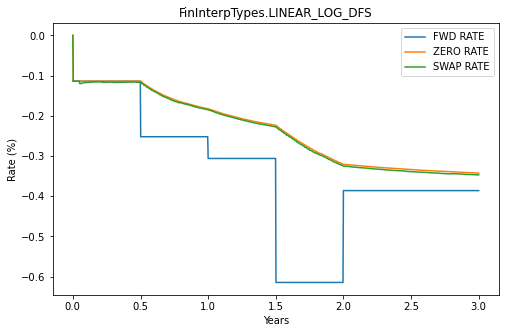

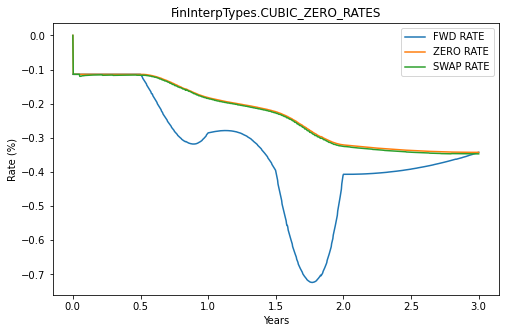

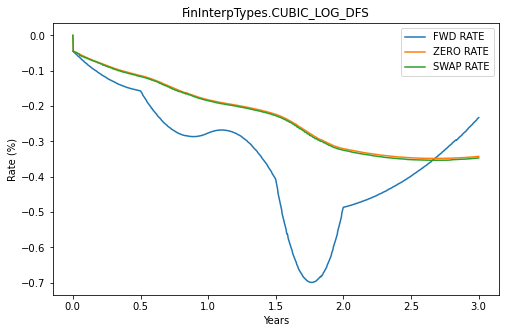

In [10]:
years = np.linspace(0, 3, 1000)
plotDates = settlementDate.addYears(years)

for interpType in FinInterpTypes:

    plt.figure(figsize=(8,5))
    iborCurve = iborCurves[interpType]
    iborCurveFwdRate = iborCurve.fwdRate(plotDates, "1D")
    iborCurveZeroRate = iborCurve.zeroRate(plotDates)
    iborCurveSwapRate = iborCurve.swapRate(settlementDate, plotDates)
    
    plt.plot(years, iborCurveFwdRate*100.0, label="FWD RATE")
    plt.plot(years, iborCurveZeroRate*100.0, label="ZERO RATE")
    plt.plot(years, iborCurveSwapRate*100.0, label="SWAP RATE")

    plt.title(interpType)
    plt.xlabel("Years")
    plt.ylabel("Rate (%)")
    plt.legend();

Copyright (c) Dominic O'Kane 2020